# Objetivo:
09/03/2021
1. Ajustar os dados do índice de isolamento a través de um polinômio
2. Utilizar $\theta$ vomo função do tempo
3. Ajustar o modelo sem vacinação com $\theta$ variável
4. Ajustar os parâmetros do modelo Covid sem vacinação

In [1]:
# Carregando librarias
# from sympy import transpose as tp
import numpy as np
import pandas as pd
#from sklearn.linear_model import LinearRegression
#from sklearn.preprocessing import PolynomialFeatures
from numpy.polynomial import polynomial as poly
import scipy.optimize as optimization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from myfunctions import rk4
from scipy.integrate import odeint

In [2]:
# parâmetros para ajustar o tamanho das figuras
#plt.rcParams['figure.figsize'] = [15, 5]
#plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

# Carregando dados do Índice de isolamento

In [3]:
# carregando data do índice de isolamento
saopaulo_isol_data = pd.read_csv("data/SaoPaulo_isolamento.csv")
saopaulo_isol_df = pd.DataFrame(saopaulo_isol_data)
saopaulo_isol_df.drop(labels='Unnamed: 0', axis=1, inplace=True)
saopaulo_isol_df = saopaulo_isol_df.rename(columns={'Isol':'Dados'})
# carregando data do índice de isolamento
campinas_isol_data = pd.read_csv("data/Campinas_isolamento.csv")
campinas_isol_df = pd.DataFrame(campinas_isol_data)
campinas_isol_df.drop(labels='Unnamed: 0', axis=1, inplace=True)
campinas_isol_df = campinas_isol_df.rename(columns={'Isol':'Dados'})
# carregando data do índice de isolamento
santos_isol_data = pd.read_csv("data/Santos_isolamento.csv")
santos_isol_df = pd.DataFrame(santos_isol_data)
santos_isol_df.drop(labels='Unnamed: 0', axis=1, inplace=True)
santos_isol_df = santos_isol_df.rename(columns={'Isol':'Dados'})

# Carregando Dados públicos do Covid-19
Obtidos do site: https://www.seade.gov.br/coronavirus/

In [4]:
# Carregando os dados para São Paulo
saopaulo_covid_df = pd.read_csv("data/SaoPaulo_dados_covid.csv")
saopaulo_covid_df.drop(labels='Unnamed: 0', axis=1, inplace=True)
saopaulo_covid_casos = saopaulo_covid_df['casos'].to_numpy()
# população total de São Paulo
saopaulo_tot_pop = int(saopaulo_covid_df['pop'].mean())
# vetor dos dias registrados 
saopaulo_dias = pd.to_datetime(saopaulo_covid_df['datahora'], yearfirst=True)
# vetor 0, 1, ..., N do tamanho das amostras coletadas
saopaulo_tempo = np.arange(0, saopaulo_covid_casos.size, 1)
# número de amostras
N_saopaulo = saopaulo_tempo.size

# Carregando os dados para Campinas
campinas_covid_df = pd.read_csv("data/Campinas_dados_covid.csv")
campinas_covid_df.drop(labels='Unnamed: 0', axis=1, inplace=True)
campinas_covid_casos = campinas_covid_df['casos'].to_numpy()
# população total de Campinas
campinas_tot_pop = int(campinas_covid_df['pop'].mean())
# vetor dos dias registrados 
campinas_dias = pd.to_datetime(campinas_covid_df['datahora'], yearfirst=True)
# vetor 0, 1, ..., N do tamanho das amostras coletadas
campinas_tempo = np.arange(0, campinas_covid_casos.size, 1)
# número de amostras
N_campinas = campinas_tempo.size

# Carregando os dados para Santos
santos_covid_df = pd.read_csv("data/Santos_dados_covid.csv")
santos_covid_df.drop(labels='Unnamed: 0', axis=1, inplace=True)
santos_covid_casos = santos_covid_df['casos'].to_numpy()
# população total de Santos
santos_tot_pop = int(santos_covid_df['pop'].mean())
# vetor dos dias registrados 
santos_dias = pd.to_datetime(santos_covid_df['datahora'], yearfirst=True)
# vetor 0, 1, ..., N do tamanho das amostras coletadas
santos_tempo = np.arange(0, santos_covid_casos.size, 1)
# número de amostras
N_santos = santos_tempo.size

# Ajustando o modelo de Covid-19 aos dados públicos
O objetivo é ajustar os parâmetros do modelo:
\begin{align}
\begin{split}
\dfrac{ds}{dt}&=\mu+\gamma -\alpha(1-\theta)si-(\mu+\gamma) s -\gamma i -\gamma s_{ick}\\
%
\dfrac{di}{dt}&=\alpha(1-\theta)si-(\beta_1+\beta_2+\mu)i\\
\dfrac{ds_{ick}}{dt}&=\beta_2i-(\beta_3+\mu)s_{ick}
\end{split}
\label{eq:constant-perc-pop-reduced-model}
\end{align}
com o índice de isolamento $\theta$ assumindo diferentes funções:
1. $\theta_1$ uma constante igual á média aritmética dos dados públicos;
2. $\theta_2(t)=at+b$, uma reta de tendência;
3. $\theta_3(t)=a_9t^9+\cdots+a_1t+a_0$, Um polinômio de ordem 9.

Para modelar a curva de casos confirmados de COVID-19 nas três cidades.

09/03/202: Após várias tentativas obteve sucesso com um fit de segunda ordem: $\theta(t)=a_2t^2+a_1t+a_0$

---

Funções a serem utilizadas em todos os casos.

In [5]:
def rhs(t,x,*p):
    # O lado direito da função    
    # ds/dt = mu + gamma - alpha(1-theta)*s*i - (mu + gamma)*s - gamma*i - gamma*sick
    # di/dt = alpha*(1-theta)*s*i - (beta1 + beta2 + mu)*i
    # dsick/dt = beta2*i - (beta3 + mu)* sick
    #
    # this is the right-hand side funtion, implemented for numertical integration
    
    # verificando número de argumentos
    if len(p)!=7:
        raise Exception("Erro no número de parâmetros!")
    s = x[0]
    i = x[1]
    sick = x[2]
    #
    mu = p[0]
    gamma = p[1]
    alpha = p[2]
    theta = p[3]
    beta1 = p[4]
    beta2 = p[5]
    beta3 = p[6]
    return np.array([mu + gamma - alpha*(1-theta(t))*s*i - (mu+gamma)*s - gamma*i - gamma*sick,
                     alpha*(1-theta(t))*s*i - (beta1+beta2+mu)*i,
                     beta2*i - (beta3+mu)*sick])      

In [6]:
# A função de chamada do optimizador
def f(x, gamma, alpha, beta1, beta2, beta3, s0, theta, mu, N):
        # in this version I adjust the initial condition so s0 + i0 + r0 = 1
        i0 = 1-s0
        r0 = 0
        x0 = np.array([s0,i0,r0]) # initial condition
        t0 = 0 # simulação comeza no dia 0
        tf = N-1 # até N-1 dias
        h = 1 # o paso de integração é um dia
        t,sol = rk4(lambda t, x: rhs(t, x, mu, gamma, alpha, theta, beta1, beta2, beta3), x0, t0, tf, h)
        return sol[:, 2]

def otimiza(theta, mu, N, dados_tempo, dados_covid_casos, dados_tot_pop):
    # Parâmetros para optimização
    sigma = None
    absolute_sigma = False
    # checar se ha algum NaN ou InF nos dados
    check_finite = True
    # os valores mínimos que os parâmetros podem tomar
    gamma_min = 0.01
    alpha_min = 0.1
    beta1_min = 0.0222
    beta2_min = 0.048
    beta3_min = 0.0222
    s0_min = 0
    # organizando os parâmetros
    params_min = [gamma_min, alpha_min, beta1_min, beta2_min, beta3_min, s0_min]
    # os valores máximos que os parâmetros podem tomar
    gamma_max = 0.1
    alpha_max = 1
    beta1_max = 0.2
    beta2_max = 0.2
    beta3_max = 0.067
    s0_max = 0.9999
    # organizando os parâmetros
    params_max = [gamma_max, alpha_max, beta1_max, beta2_max, beta3_max, s0_max]
    # organizando os vetores dos limites inferirior e superior
    bounds = (params_min, params_max)
    # método de otimização (escoler um deles)
    # ‘dogbox’ : dogleg algorithm with rectangular trust regions,
    # 'trf' : Trust Region Reflective algorithm
    method = 'trf'
    # Jacobiano
    jac = None
    # chute inicial para os parâmetros, para ajustar o resultado da simulação podemos ajustar esses chutes iniciais
    gamma_0 = 0.02
    alpha_0 = 0.6
    beta1_0 = 0.07
    beta2_0 = 0.08
    beta3_0 = 0.04
    s0_0 = 0.99
    # organizando os parâmetros
    p0 = np.array([gamma_0, alpha_0, beta1_0, beta2_0, beta3_0, s0_0])
    # a otimização
    print('\nRunning the optimization ...')
    f_adj = lambda x, gamma, alpha, beta1, beta2, beta3, s0: f(x, gamma, alpha, beta1, beta2, beta3, s0, theta, mu, N)
    popt, pvoc = optimization.curve_fit(f_adj, dados_tempo, dados_covid_casos/dados_tot_pop, p0, sigma, absolute_sigma, check_finite, bounds,method, jac)
    return(popt, pvoc)

In [7]:
def otimiza_2(p0):
    # Parâmetros para optimização
    sigma = None
    absolute_sigma = False
    # checar se ha algum NaN ou InF nos dados
    check_finite = True
    # os valores mínimos que os parâmetros podem tomar
    gamma_min = 0.01
    alpha_min = 0.1
    beta1_min = 0.0222
    beta2_min = 0.048
    beta3_min = 0.0222
    s0_min = 0
    # organizando os parâmetros
    params_min = [gamma_min, alpha_min, beta1_min, beta2_min, beta3_min, s0_min]
    # os valores máximos que os parâmetros podem tomar
    gamma_max = 0.1
    alpha_max = 1
    beta1_max = 0.2
    beta2_max = 0.2
    beta3_max = 0.067
    s0_max = 0.9999
    # organizando os parâmetros
    params_max = [gamma_max, alpha_max, beta1_max, beta2_max, beta3_max, s0_max]
    # organizando os vetores dos limites inferirior e superior
    bounds = (params_min, params_max)
    # método de otimização (escoler um deles)
    # ‘dogbox’ : dogleg algorithm with rectangular trust regions,
    # 'trf' : Trust Region Reflective algorithm
    method = 'trf'
    # Jacobiano
    jac = None
    # chute inicial para os parâmetros, para ajustar o resultado da simulação podemos ajustar esses chutes iniciais
    #gamma_0 = p0[0]
    #alpha_0 = p0[1]
    #beta1_0 = p0[2]
    #beta2_0 = p0[3]
    #beta3_0 = p0[4]
    #s0_0 = p0[5]
    # organizando os parâmetros
    p0 = np.array([gamma_0, alpha_0, beta1_0, beta2_0, beta3_0, s0_0])
    # a otimização
    print('\nRunning the optimization ...') 
    popt, pvoc = optimization.curve_fit(f, saopaulo_tempo, saopaulo_covid_casos/saopaulo_tot_pop, p0, sigma, absolute_sigma, check_finite, bounds,method, jac)
    return(popt, pvoc)

# Ajuste para cidade de São Paulo

## Ajustado o Índice de isolamento para cidade de São Paulo

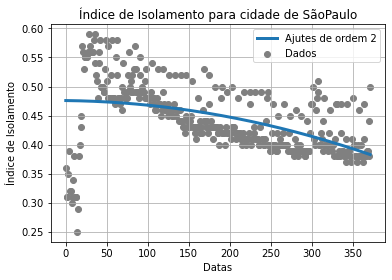

In [7]:
# Ajustando os polinômios com dados crus 
X_saopaulo = np.arange(0,saopaulo_isol_df['Dados'].size, 1)
#
poly_order = 2
coefs, stats = poly.polyfit(X_saopaulo, saopaulo_isol_df['Dados'].to_numpy(), poly_order , full=True)
ffit_saopaulo = np.polynomial.Polynomial(coefs)
#
plt.scatter(X_saopaulo,saopaulo_isol_df['Dados'].to_numpy(), color='gray', label='Dados')
#plt.plot(X,ffit9(X), linewidth=3, label='pol. ordem 9')
#plt.plot(X,ffit7(X), linewidth=3, label='pol. ordem 7')
#plt.plot(X,ffit5(X), linewidth=3, label='pol. ordem 5')
#plt.plot(X,ffit3(X), linewidth=3, label='pol. ordem 3')
#plt.plot(X,ffit2(X), linewidth=3, label='pol. ordem 2')
plt.plot(X_saopaulo,ffit_saopaulo(X_saopaulo), linewidth=3, label='Ajutes de ordem '+str(poly_order))
plt.legend()
plt.grid()
plt.xlabel('Datas')
plt.ylabel('Índice de Isolamento')
plt.title("Índice de Isolamento para cidade de SãoPaulo")
plt.show()

## Ajuste do modelo

In [9]:
# Taxa diaria de nacimentos e mortes
mu_saopaulo = 3.595e-05 # (Aqui estou utilizando o dado utilizado no artigo anterior) (utilizei 2e-5 nas simulações anteriores)
#mu = mu_saopaulo
#N = N_saopaulo
#theta = ffit_saopaulo

Rodando a otimização ...

In [10]:
#otimiza(theta, mu, N, dados_tempo, dados_covid_casos, dados_tot_pop)
popt_1, pvoc_1 = otimiza(ffit_saopaulo, mu_saopaulo, N_saopaulo, saopaulo_tempo, saopaulo_covid_casos, saopaulo_tot_pop)
print('optimização finalizada.')


Running the optimization ...
optimização finalizada.


Os parâmetros:

In [13]:
perr = np.sqrt(np.diag(pvoc_1))
print('Standard deviation errors on the parameters = ', perr)
print('\nParameters:')
print('-----------')
print('mu =', mu_saopaulo)
print('theta =', ffit_saopaulo)
print('Fitted parameters:')
gamma_opt = popt_1[0]
print('gamma =', gamma_opt)
alpha_opt = popt_1[1]
print('alpha =', alpha_opt)
beta1_opt = popt_1[2]
print('beta1 =', beta1_opt)
beta2_opt = popt_1[3]
print('beta2 =', beta2_opt)
beta3_opt = popt_1[4]
print('beta3 =', beta3_opt)
s0_opt = popt_1[5]
print('s0 =', s0_opt)
i0_opt = 1-s0_opt
print('i0 =', i0_opt)

Standard deviation errors on the parameters =  [1.41578759e-03 1.91705898e-02 5.92092025e-02 5.52334281e-02
 1.76309315e-02 1.44973288e-05]

Parameters:
-----------
mu = 3.595e-05
theta = poly([ 4.75954638e-01 -1.66832492e-05 -6.29817136e-07])
Fitted parameters:
gamma = 0.03525638927991451
alpha = 0.8091207750384241
beta1 = 0.19999999999999998
beta2 = 0.19999999999999998
beta3 = 0.05949599308206998
s0 = 0.9997584407011388
i0 = 0.00024155929886116034


Simulação numerica do ajuste:

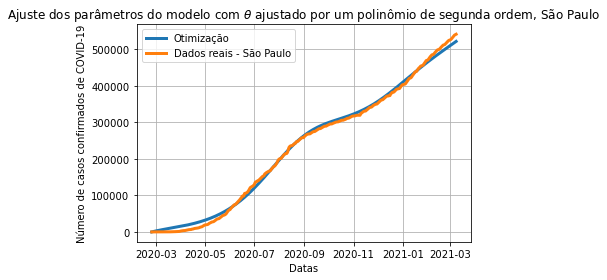

In [17]:
# initial condition
x0 = np.array([s0_opt, i0_opt, 0])
# parameters
t0 = 0
tf = N_saopaulo-1
h = 1
#    
# rodando Runge-Kutta de 4ta ordem de passo fixo
t, sol =  rk4(lambda t, x: rhs(t, x, mu_saopaulo, gamma_opt, alpha_opt, ffit_saopaulo, beta1_opt, beta2_opt, beta3_opt), x0, t0, tf, h)
# o gráfico do ajuste
plt.plot(saopaulo_dias, sol[:,2]*saopaulo_tot_pop, linewidth=3, label='Otimização')
plt.plot(saopaulo_dias, saopaulo_covid_casos, linewidth=3, label='Dados reais - São Paulo')
plt.grid()
plt.legend()
plt.title('Ajuste dos parâmetros do modelo com $\\theta$ ajustado por um polinômio de segunda ordem, São Paulo')
plt.xlabel('Datas')
plt.ylabel('Número de casos confirmados de COVID-19')
plt.show()

# Salvar os parâmetros para uso nas simulações

In [58]:
# salvamos os parâmetros da otimização,
parametros_otimos = {
    'Parametros':['mu', 'gamma', 'alpha', 'beta1', 'beta2', 'beta3', 's0', 'i0'],\
    'Valor':[mu, gamma_opt, alpha_opt, beta1_opt, beta2_opt, beta3_opt, s0_opt, i0_opt]}
parametros_df = pd.DataFrame(data=parametros_otimos, columns= ['Parametros', 'Valor'])
parametros_df.to_csv('saopaulo_param_otim.csv', index=False)

In [59]:
# adicionalmente salvamos a simulação obtida.
simul = np.concatenate((t.reshape(-1,1),sol),axis=1)
simul_df = pd.DataFrame(data=simul, columns=['tempo', 's', 'i', 'sick'])
simul_df.to_csv('sao_paulo_simula_otim.csv', index=False)

# Ajuste para cidade de Campinas

## Ajustando o índice de isolamento para cidade de Campinas

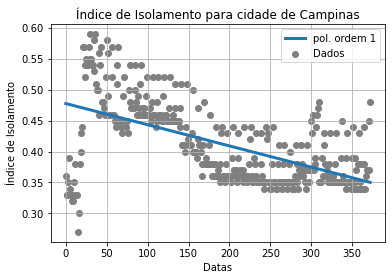

In [62]:
# Ajustando os polinômios com dados crus 
X_campinas = np.arange(0,campinas_isol_df['Dados'].size, 1)
#
poly_order = 1
coefs, stats = poly.polyfit(X_campinas, campinas_isol_df['Dados'].to_numpy(), poly_order, full=True)
ffit_campinas = np.polynomial.Polynomial(coefs)
#
plt.scatter(X_campinas,campinas_isol_df['Dados'].to_numpy(), color='gray', label='Dados')
plt.plot(X_campinas,ffit_campinas(X_campinas), linewidth=3, label='pol. ordem '+str(poly_order))
plt.legend()
plt.grid()
plt.xlabel('Datas')
plt.ylabel('Índice de Isolamento')
plt.title("Índice de Isolamento para cidade de Campinas")
plt.show()

## Rodando o Fitting

In [63]:
# Taxa diaria de nacimentos e mortes
mu_campinas = 3.353e-05 # (Aqui estou utilizando o dado utilizado no artigo anterior) (utilizei 2e-5 nas simulações anteriores)

Rodando a otimização ...

In [64]:
popt_2, pvoc_2 = otimiza(ffit_campinas, mu_campinas, N_campinas, campinas_tempo, campinas_covid_casos, campinas_tot_pop)
print('optimização finalizada.')


Running the optimization ...
optimização finalizada.


Os parâmetros:

Standard deviation errors on the parameters =  [1.41578759e-03 1.91705898e-02 5.92092025e-02 5.52334281e-02
 1.76309315e-02 1.44973288e-05]

Parameters:
-----------
mu = 3.353e-05
theta = poly([ 4.77820533e-01 -3.43005835e-04])
Fitted parameters:
gamma = 0.04231965997211562
alpha = 0.7676759077233608
beta1 = 0.1999999999999549
beta2 = 0.19999999999754026
beta3 = 0.06699999999999999
s0 = 0.9993964047156829
i0 = 0.0006035952843170822


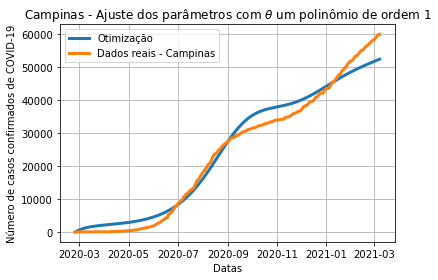

In [65]:
perr = np.sqrt(np.diag(pvoc_1))
print('Standard deviation errors on the parameters = ', perr)
print('\nParameters:')
print('-----------')
print('mu =', mu_campinas)
print('theta =', ffit_campinas)
print('Fitted parameters:')
gamma_opt = popt_2[0]
print('gamma =', gamma_opt)
alpha_opt = popt_2[1]
print('alpha =', alpha_opt)
beta1_opt = popt_2[2]
print('beta1 =', beta1_opt)
beta2_opt = popt_2[3]
print('beta2 =', beta2_opt)
beta3_opt = popt_2[4]
print('beta3 =', beta3_opt)
s0_opt = popt_2[5]
print('s0 =', s0_opt)
i0_opt = 1-s0_opt
print('i0 =', i0_opt)

# Simulação numerica do ajuste:

# initial condition
x0 = np.array([s0_opt, i0_opt, 0])
# parameters
t0 = 0
tf = N_campinas-1
h = 1
#    
# rodando Runge-Kutta de 4ta ordem de passo fixo
t, sol =  rk4(lambda t, x: rhs(t, x, mu_campinas, gamma_opt, alpha_opt, ffit_campinas, beta1_opt, beta2_opt, beta3_opt), x0, t0, tf, h)
# o gráfico do ajuste
plt.plot(campinas_dias, sol[:,2]*campinas_tot_pop, linewidth=3, label='Otimização')
plt.plot(campinas_dias, campinas_covid_casos, linewidth=3, label='Dados reais - Campinas')
plt.grid()
plt.legend()
plt.title('Campinas - Ajuste dos parâmetros com $\\theta$ um polinômio de ordem '+str(poly_order))
plt.xlabel('Datas')
plt.ylabel('Número de casos confirmados de COVID-19')
plt.show()

# Ajuste para Santos

## Ajustando o índice de isolamento para cidade de Campinas

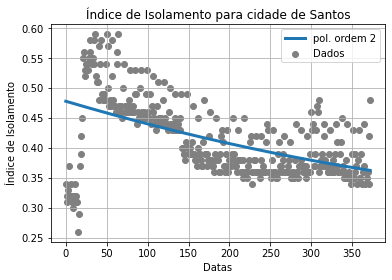

In [76]:
# Ajustando os polinômios com dados crus 
X_santos = np.arange(0,santos_isol_df['Dados'].size, 1)
#
poly_order = 2
coefs, stats = poly.polyfit(X_santos, santos_isol_df['Dados'].to_numpy(), poly_order, full=True)
ffit_santos = np.polynomial.Polynomial(coefs)
#
plt.scatter(X_santos,santos_isol_df['Dados'].to_numpy(), color='gray', label='Dados')
plt.plot(X_santos,ffit_santos(X_santos), linewidth=3, label='pol. ordem ' + str(poly_order))
plt.legend()
plt.grid()
plt.xlabel('Datas')
plt.ylabel('Índice de Isolamento')
plt.title("Índice de Isolamento para cidade de Santos")
plt.show()

## Rodando o Fitting

In [77]:
# Taxa diaria de nacimentos e mortes
mu_santos = 2.693e-05 # (Aqui estou utilizando o dado utilizado no artigo anterior) (utilizei 2e-5 nas simulações anteriores)

Rodando a otimização.

In [78]:
#theta = ffit_santos
#gamma_0 = 0.04
#alpha_0 = 0.5
#beta1_0 = 0.07
#beta2_0 = 0.08
#beta3_0 = 0.04
#s0_0 = 0.99
# Condições iniciais do fit
#p0_santos = np.zeros(6)
#p0_santos[0] = gamma_0
#p0_santos[1] = alpha_0
#p0_santos[2] = beta1_0
#p0_santos[3] = beta2_0
#p0_santos[4] = beta3_0
#p0_santos[5] = s0_0
#
popt_3, pvoc_3 = otimiza(ffit_santos, mu_santos, N_santos, santos_tempo, santos_covid_casos, santos_tot_pop)
#
print('optimização finalizada.')


Running the optimization ...
optimização finalizada.


Os parâmetros:

Standard deviation errors on the parameters =  [1.41578759e-03 1.91705898e-02 5.92092025e-02 5.52334281e-02
 1.76309315e-02 1.44973288e-05]

Parameters:
-----------
mu = 2.693e-05
theta = poly([ 4.78158943e-01 -4.03452557e-04  2.50013260e-07])
Fitted parameters:
gamma = 0.09999999999999999
alpha = 0.5133702997529784
beta1 = 0.19999999996773402
beta2 = 0.06050105778538201
beta3 = 0.022200000000000004
s0 = 0.9976207943806061
i0 = 0.002379205619393865


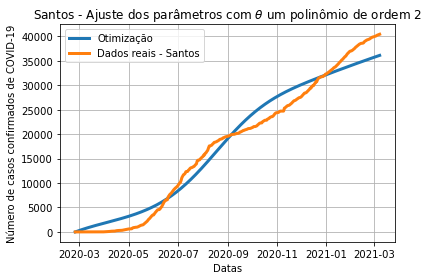

In [79]:
perr = np.sqrt(np.diag(pvoc_1))
print('Standard deviation errors on the parameters = ', perr)
print('\nParameters:')
print('-----------')
print('mu =', mu_santos)
print('theta =', ffit_santos)
print('Fitted parameters:')
gamma_opt = popt_3[0]
print('gamma =', gamma_opt)
alpha_opt = popt_3[1]
print('alpha =', alpha_opt)
beta1_opt = popt_3[2]
print('beta1 =', beta1_opt)
beta2_opt = popt_3[3]
print('beta2 =', beta2_opt)
beta3_opt = popt_3[4]
print('beta3 =', beta3_opt)
s0_opt = popt_3[5]
print('s0 =', s0_opt)
i0_opt = 1-s0_opt
print('i0 =', i0_opt)

# Simulação numerica do ajuste:

# initial condition
x0 = np.array([s0_opt, i0_opt, 0])
# parameters
t0 = 0
tf = N_santos-1
h = 1
#    
#p=np.zeros(7)
#p[0] = mu
#p[1] = gamma_opt
#p[2] = alpha_opt
#p[3] = theta
#p[3] = beta1_opt
#p[4] = beta2_opt
#p[5] = beta3_opt
# rodando Runge-Kutta de 4ta ordem de passo fixo
t, sol =  rk4(lambda t, x: rhs(t, x, mu_santos, gamma_opt, alpha_opt, ffit_santos, beta1_opt, beta2_opt, beta3_opt), x0, t0, tf, h)
# o gráfico do ajuste
plt.plot(santos_dias, sol[:,2]*santos_tot_pop, linewidth=3, label='Otimização')
plt.plot(santos_dias, santos_covid_casos, linewidth=3, label='Dados reais - Santos')
plt.grid()
plt.legend()
plt.title('Santos - Ajuste dos parâmetros com $\\theta$ um polinômio de ordem '+str(poly_order))
plt.xlabel('Datas')
plt.ylabel('Número de casos confirmados de COVID-19')
plt.show()